In [29]:
import os
import matplotlib.pyplot as plt
import math

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import datetime

from psycopg2 import sql, connect
from sqlalchemy import create_engine, text

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from train_test.general import train_test_bookies_comparison, display_train_test_bookies_comparison, train_test
from train_test.split import train_test_split_expanding_windows, train_test_split_sliding_windows
from feature_eng.odds import bookie_prediction, prob_by_bookies
from train_test.metrics import accuracy_fn, classwise_ECE_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, precision_fn, recall_fn
from feature_eng.team_stats import goal_stats, elo_scores, glicko2_scores, trueskill_scores

from feature_eng.format_df import merge_sofifa_fbref_results, format_sofifa_fbref_data, add_signals

import tqdm

from optim.functions.player_gain_expected_value import player_gain_expected_value, player_gain_expected_value_numpy
from optim.functions.player_gain_variance import player_gain_variance, player_gain_variance_numpy
from optim.functions.player_utility_kelly_criteria import player_utility_kelly_criteria
from optim.functions.player_utility_linear import player_utility_linear
from optim.functions.player_utility_sharp_ratio import player_utility_sharp_ratio
from optim.functions.player_expected_utility import player_expected_utility
from optim.functions.player_expected_utility_exp_ce import player_expected_utility_exp_ce
from optim.functions.player_expected_utility_log import player_expected_utility_log

from optim.resolve.resolve_fik import resolve_fik
from optim.resolve.simulate_prob import simulate_prob



In [2]:

load_dotenv("./../../secrets.env")
DB_USER = 'kube'
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = 'localhost'
DB_PORT = 8110
DB_NAME = 'optimsportbets-db'

DB_TN_FBREF_RESULTS = 'fbref_results'
DB_TN_ODDS = 'soccer_odds'
DB_TN_SOFIFA_TEAMS_STATS = 'sofifa_teams_stats'
DB_TN_MODELS_RESULTS = 'models_results'
DB_TN_OPTIM_RESULTS = 'optim_results'

In [3]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_FBREF_RESULTS}")
    fbref_results_df = pd.read_sql(query, connection)
    sofifa_teams_stats_df = pd.read_sql(f'SELECT * FROM {DB_TN_SOFIFA_TEAMS_STATS}', connection)
    odds_df = pd.read_sql(f'SELECT * FROM {DB_TN_ODDS}', connection)

In [4]:
odds_df

,match_id,sport_key,sport_title,commence_time,home_team,away_team,bookmaker_key,bookmaker_title,bookmaker_last_update,market_key,market_last_update,outcome_name,outcome_price,datetime_insert
0,c3f950a4b9e19115303fbbe760ebc8da,soccer_uefa_europa_conference_league,UEFA Europa Conference League,2024-07-25 18:45:00,Víkingur Reykjavík,KF Egnatia,pinnacle,Pinnacle,2024-07-25 10:47:56,h2h,2024-07-25 10:47:56,KF Egnatia,4.44,2024-09-24 09:17:32.177228
1,c3f950a4b9e19115303fbbe760ebc8da,soccer_uefa_europa_conference_league,UEFA Europa Conference League,2024-07-25 18:45:00,Víkingur Reykjavík,KF Egnatia,pinnacle,Pinnacle,2024-07-25 10:47:56,h2h,2024-07-25 10:47:56,Víkingur Reykjavík,1.74,2024-09-24 09:17:32.177228
2,c3f950a4b9e19115303fbbe760ebc8da,soccer_uefa_europa_conference_league,UEFA Europa Conference League,2024-07-25 18:45:00,Víkingur Reykjavík,KF Egnatia,pinnacle,Pinnacle,2024-07-25 10:47:56,h2h,2024-07-25 10:47:56,Draw,3.60,2024-09-24 09:17:32.177228
3,c3f950a4b9e19115303fbbe760ebc8da,soccer_uefa_europa_conference_league,UEFA Europa Conference League,2024-07-25 18:45:00,Víkingur Reykjavík,KF Egnatia,betclic,Betclic,2024-07-25 10:47:56,h2h,2024-07-25 10:47:56,KF Egnatia,4.10,2024-09-24 09:17:32.177228
4,c3f950a4b9e19115303fbbe760ebc8da,soccer_uefa_europa_conference_league,UEFA Europa Conference League,2024-07-25 18:45:00,Víkingur Reykjavík,KF Egnatia,betclic,Betclic,2024-07-25 10:47:56,h2h,2024-07-25 10:47:56,Víkingur Reykjavík,1.72,2024-09-24 09:17:32.177228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98086,4103fe10dc7d21ffe77840763a7e1437,soccer_epl,EPL,2024-10-21 19:00:00,Nottingham Forest,Crystal Palace,nordicbet,Nordic Bet,2024-09-30 09:49:40,h2h,2024-09-30 09:49:40,Nottingham Forest,2.58,2024-09-30 09:50:04.883423
98087,4103fe10dc7d21ffe77840763a7e1437,soccer_epl,EPL,2024-10-21 19:00:00,Nottingham Forest,Crystal Palace,nordicbet,Nordic Bet,2024-09-30 09:49:40,h2h,2024-09-30 09:49:40,Draw,3.30,2024-09-30 09:50:04.883423
98088,4103fe10dc7d21ffe77840763a7e1437,soccer_epl,EPL,2024-10-21 19:00:00,Nottingham Forest,Crystal Palace,betsson,Betsson,2024-09-30 09:49:41,h2h,2024-09-30 09:49:41,Crystal Palace,2.82,2024-09-30 09:50:04.883423
98089,4103fe10dc7d21ffe77840763a7e1437,soccer_epl,EPL,2024-10-21 19:00:00,Nottingham Forest,Crystal Palace,betsson,Betsson,2024-09-30 09:49:41,h2h,2024-09-30 09:49:41,Nottingham Forest,2.62,2024-09-30 09:50:04.883423


In [4]:
date_stop = datetime.datetime.now()
fbref_results_df__sofifa_merged = merge_sofifa_fbref_results(fbref_results_df, sofifa_teams_stats_df)
fbref_results_df__sofifa_merged__data_formated = format_sofifa_fbref_data(fbref_results_df__sofifa_merged, date_stop=date_stop)
fbref_results_df__sofifa_merged__data_formated__signals_added = add_signals(fbref_results_df__sofifa_merged__data_formated, date_stop=date_stop)

rule_is_before_datetime = fbref_results_df__sofifa_merged__data_formated__signals_added["datetime"] < date_stop
fbref_results_df__sofifa_merged__data_formated__signals_added__train = fbref_results_df__sofifa_merged__data_formated__signals_added[rule_is_before_datetime]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer = fbref_results_df__sofifa_merged__data_formated__signals_added[~rule_is_before_datetime]

In [5]:
# X_col_sofifa =  ['home_overall', 'home_attack', 
#             'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
#             'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
#             'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
#             'away_starting_xi_average_age', 'away_whole_team_average_age']

# X_col_scores = [
#     'elo_home_before', 'elo_away_before',
#     'home_team_number_of_match_played', 'away_team_number_of_match_played',
#     'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
#     'glicko2_rd_away_before', 'glicko2_vol_home_before',
#     'glicko2_vol_away_before', 'trueskill_home_before',
#     'trueskill_away_before', 'home_team_goals_season_to_date_before_match',
# 'away_team_goals_season_to_date_before_match',
# 'avg_home_team_goals_season_to_date_before_match',
# 'avg_away_team_goals_season_to_date_before_match']

# X_cat = ['home_league',
#  'home_build_up_speed',
#  'home_build_up_dribbling',
#  'home_build_up_passing',
#  'home_build_up_positioning',
#  'home_chance_creation_crossing',
#  'home_chance_creation_passing',
#  'home_chance_creation_shooting',
#  'home_chance_creation_positioning',
#  'home_defence_aggression',
#  'home_defence_pressure',
#  'home_defence_team_width',
#  'home_defence_defender_line',
#  'away_league',
#  'away_build_up_speed',
#  'away_build_up_dribbling',
#  'away_build_up_passing',
#  'away_build_up_positioning',
#  'away_chance_creation_crossing',
#  'away_chance_creation_passing',
#  'away_chance_creation_shooting',
#  'away_chance_creation_positioning',
#  'away_defence_aggression',
#  'away_defence_pressure',
#  'away_defence_team_width',
#  'away_defence_defender_line',]

features = [
    "elo_away_before",
    "elo_home_before",
    "glicko2_vol_away_before",
    "away_overall",
    "home_overall",
    "away_build_up_speed_Slow",
    "away_starting_xi_average_age",
    "home_league_INT",
    "avg_home_team_goals_season_to_date_before_match",
    "home_build_up_positioning_Organised",
    "home_build_up_speed_Fast",
    "away_defence_pressure_High",
    "away_defence_defender_line_Offside trap",
    "home_league_ITA-Serie A",
    "glicko2_rd_home_before",
    "home_chance_creation_shooting_Normal",
    "away_build_up_passing_Mixed",
    "away_team_goals_season_to_date_before_match",
    "home_chance_creation_passing_Risky",
    "away_chance_creation_positioning_Organised",
    "away_defence_pressure_Medium",
    "away_defence_domestic_prestige",
    "away_chance_creation_shooting_Lots",
    "home_defence_defender_line_Offside trap",
    "away_defence_team_width_Wide",
    "home_defence_pressure_Medium",
    "home_build_up_speed_Slow",
    "away_defence_aggression_Press",
    "trueskill_home_before",
    "away_build_up_positioning_Organised",
    "away_defence",
    "home_attack",
    "home_defence_domestic_prestige",
    "away_attack",
    "away_league_INT",
    "away_league_ITA-Serie A",
    "home_chance_creation_crossing_Normal",
    "home_defence_team_width_Wide",
    "away_players",
    "away_chance_creation_crossing_Normal",
    "glicko2_rd_away_before",
    "home_starting_xi_average_age",
    "home_whole_team_average_age",
    "away_chance_creation_passing_Risky",
    "away_chance_creation_passing_Safe",
    "away_chance_creation_shooting_Normal",
    "away_chance_creation_crossing_Lots",
    "away_defence_aggression_Double",
    "home_players",
    "away_build_up_speed_Fast",
    "away_transfer_budget",
    "home_team_goals_season_to_date_before_match",
    "home_team_number_of_match_played",
    "home_defence",
    "trueskill_away_before",
    "home_chance_creation_passing_Safe",
    "away_defence_team_width_Normal",
    "away_team_number_of_match_played",
    "home_club_worth",
    "away_build_up_dribbling_Normal",
    "home_build_up_passing_Short",
    "home_chance_creation_crossing_Lots",
    "away_club_worth",
    "home_build_up_dribbling_Normal",
    "home_build_up_dribbling_Lots",
    "home_defence_aggression_Press",
    "away_midfield",
    "glicko2_home_before",
    "away_whole_team_average_age",
    "away_build_up_passing_Short",
    "glicko2_vol_home_before",
    "glicko2_away_before",
    "avg_away_team_goals_season_to_date_before_match",
    "home_build_up_passing_Mixed",
    "home_transfer_budget",
    "home_chance_creation_positioning_Organised",
    "home_midfield",
    "home_defence_team_width_Normal",
    "home_defence_pressure_High",
    "home_league_ESP-La Liga",
    "away_league_ESP-La Liga",
    "away_build_up_dribbling_Lots",
    "home_defence_aggression_Double",
    "home_chance_creation_shooting_Lots",
    "away_international_prestige",
    "home_international_prestige"
]


# All features
# df_cat_onehot = pd.get_dummies(fbref_results_df__sofifa_merged__data_formated__signals_added__train[X_cat], drop_first=True)
# df_all = pd.concat([fbref_results_df__sofifa_merged__data_formated__signals_added__train, df_cat_onehot], axis=1)

pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

Y_col = 'FTR'
X_col = features[:35]

In [6]:
df_all = fbref_results_df__sofifa_merged__data_formated__signals_added__train
df_all[['game', 'FTR']]

,game,FTR
3,2006-09-09 Everton-Liverpool,1.0
6,2006-09-09 Fiorentina-Inter,-1.0
7,2006-09-09 Barcelona-Osasuna,1.0
8,2006-09-09 Atlético Madrid-Valencia,-1.0
14,2006-09-09 Nantes-Lille,0.0
...,...,...
32088,2024-09-29 Manchester Utd-Tottenham,-1.0
32089,2024-09-29 Empoli-Fiorentina,0.0
32090,2024-09-29 Roma-Venezia,1.0
32091,2024-09-29 Torino-Lazio,-1.0


In [7]:
date_stop = datetime.datetime(2024, 10, 2)
df_all[df_all['date'] < date_stop].sort_values('date', ascending=False)[['game', 'score']].head(50)

,game,score
32098,2024-09-29 Napoli-Monza,2–0
32084,2024-09-29 Athletic Club-Sevilla,1–1
32077,2024-09-29 Toulouse-Lyon,1–2
32078,2024-09-29 Strasbourg-Marseille,1–0
32079,2024-09-29 Nantes-Saint-Étienne,2–2
32081,2024-09-29 Holstein Kiel-Eint Frankfurt,2–4
32082,2024-09-29 Como-Hellas Verona,3–2
32083,2024-09-29 Hoffenheim-Werder Bremen,3–4
32080,2024-09-29 Angers-Reims,1–3
32085,2024-09-29 Atlético Madrid-Real Madrid,1–1


In [21]:
def compute_prob(df_all, date_stop_train):
    #date_stop_train = datetime.datetime(2015, 1, 1)
    train = df_all[df_all['datetime'] < date_stop_train]
    test = df_all[df_all['datetime'] >= date_stop_train]

    result_col_name = 'FTR'
    model_predictions_col_name = 'pred'
    model_predictions_prob_home_col_name = 'prob_home_win'
    model_predictions_prob_draw_col_name = 'prob_draw'
    model_predictions_prob_away_col_name = 'prob_away_win'

    X_train = train[X_col]
    Y_train = train[Y_col]
    X_test = test[X_col]

    pipeline.fit(X_train, Y_train.values.ravel())
    predictions = pipeline.predict(X_test)
    prob_predictions = pipeline.predict_proba(X_test)

    result_df = test.copy()
    result_df.loc[:, model_predictions_col_name] = predictions
    result_df.loc[:, model_predictions_prob_home_col_name] = prob_predictions[:, 2]
    result_df.loc[:, model_predictions_prob_draw_col_name] = prob_predictions[:, 1]
    result_df.loc[:, model_predictions_prob_away_col_name] = prob_predictions[:, 0]

    metrics = {}
    metrics["accuracy"], metrics["weighted_accuracy"], (metrics["accuracy_home"], metrics["accuracy_draw"], metrics["accuracy_away"]) = accuracy_fn(result_df, result_col_name, model_predictions_col_name)
    metrics["macro_avg_recall"], metrics["micro_avg_recall"], metrics["weighted_recall"], (metrics["recall_home"], metrics["recall_draw"], metrics["recall_away"]) = recall_fn(result_df, result_col_name, model_predictions_col_name)
    metrics["macro_avg_precision"], metrics["micro_avg_precision"], metrics["weighted_precision"], (metrics["precision_home"], metrics["precision_draw"], metrics["precision_away"]) = precision_fn(result_df, result_col_name, model_predictions_col_name)
    metrics["macro_avg_f_mesure"], metrics["micro_avg_f_mesure"], metrics["weighted_f_mesure"], (metrics["f_mesure_home"], metrics["f_mesure_draw"], metrics["f_mesure_away"]) = f_mesure_fn(result_df, result_col_name, model_predictions_col_name)
    metrics["log_loss"], (metrics["loss_home"], metrics["loss_draw"], metrics["loss_away"]) = log_loss_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)
    metrics["mse"], (metrics["mse_home"], metrics["mse_draw"], metrics["mse_away"]) = mse_loss_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)
    metrics["classwise_ECE"], (metrics["ECE_home"], metrics["ECE_draw"], metrics["ECE_away"]), (metrics["home_ECE_y"], metrics["draw_ECE_y"], metrics["away_ECE_y"]), (metrics["home_ECE_p"], metrics["draw_ECE_p"], metrics["away_ECE_p"]), (metrics["home_ECE_size"], metrics["draw_ECE_size"], metrics["away_ECE_size"]) = classwise_ECE_fn(result_df[result_col_name], result_df[model_predictions_prob_home_col_name], result_df[model_predictions_prob_draw_col_name], result_df[model_predictions_prob_away_col_name], all_results=True)

    result_df['datetime_inference'] = datetime.datetime.now()
    result_df.loc[:, "date_match"] = result_df["date"]
    result_df.loc[:, "time_match"] = result_df["time"]
    return result_df, metrics

In [108]:
def compute_ot(df_odds, df_models_results, datetime_first_match, n_matches=None, same_day=False, bookmakers=None):

    mapping_dict = {
    '1. FC Heidenheim': 'Heidenheim',
    'AC Milan': 'Milan',
    'AS Monaco': 'Monaco',
    'AS Roma': 'Roma',
    'Atalanta BC': 'Atalanta',
    'Athletic Bilbao': 'Athletic Club',
    'Bayer Leverkusen': 'Leverkusen',
    'Borussia Dortmund': 'Dortmund',
    'Borussia Monchengladbach': 'Gladbach',
    'Brighton and Hove Albion': 'Brighton',
    'CA Osasuna': 'Osasuna',
    'Eintracht Frankfurt': 'Eint Frankfurt',
    'FC St. Pauli': 'St. Pauli',
    'FSV Mainz 05': 'Mainz 05',
    'Inter Milan': 'Inter',
    'Manchester United': 'Manchester Utd',
    'Newcastle United': 'Newcastle Utd',
    'Nottingham Forest': "Nott'ham Forest",
    'Paris Saint Germain': 'Paris S-G',
    'RC Lens': 'Lens',
    'SC Freiburg': 'Freiburg',
    'Saint Etienne': 'Saint-Étienne',
    'TSG Hoffenheim': 'Hoffenheim',
    'Tottenham Hotspur': 'Tottenham',
    'VfB Stuttgart': 'Stuttgart',
    'VfL Bochum': 'Bochum',
    'VfL Wolfsburg': 'Wolfsburg',
    'West Ham United': 'West Ham',
    'Wolverhampton Wanderers': 'Wolves'
}

    # Filter the odds data to keep only the last odds before last_odds_datetime for each outcome
    last_odds_datetime = datetime_first_match
    df_odds__last_odds = df_odds[df_odds['bookmaker_last_update'] <= last_odds_datetime]
    df_odds__last_odds = df_odds.sort_values(by=['commence_time', 'match_id', 'bookmaker_key', 'bookmaker_last_update'], ascending=False)
    df_odds__last_odds = df_odds__last_odds.drop_duplicates(subset=['match_id', 'bookmaker_key', 'outcome_name'], keep='first')

    # Put on the same line the odds for each outcome for each match and each bookmaker
    df_odds__last_odds__home = df_odds__last_odds[df_odds__last_odds['outcome_name'] == df_odds__last_odds['home_team']]
    df_odds__last_odds__away = df_odds__last_odds[df_odds__last_odds['outcome_name'] == df_odds__last_odds['away_team']]
    df_odds__last_odds__draw = df_odds__last_odds[df_odds__last_odds['outcome_name'] == 'Draw']
    df_odds__last_odds__home = df_odds__last_odds__home.rename(columns={'outcome_price': 'odds_home'})
    df_odds__last_odds__away = df_odds__last_odds__away.rename(columns={'outcome_price': 'odds_away'})
    df_odds__last_odds__draw = df_odds__last_odds__draw.rename(columns={'outcome_price': 'odds_draw'})
    df_odds__last_odds__home['odds_home_datetime'] = df_odds__last_odds__home['bookmaker_last_update']
    df_odds__last_odds__draw['odds_draw_datetime'] = df_odds__last_odds__draw['bookmaker_last_update']
    df_odds__last_odds__away['odds_away_datetime'] = df_odds__last_odds__away['bookmaker_last_update']
    df_odds__last_odds__draw = df_odds__last_odds__draw[['match_id', 'bookmaker_key', 'odds_draw', 'odds_draw_datetime']]
    df_odds__last_odds__away = df_odds__last_odds__away[['match_id', 'bookmaker_key', 'odds_away', 'odds_away_datetime']]
    df_odds__last_odds__home_draw = pd.merge(df_odds__last_odds__home, df_odds__last_odds__draw, on=['match_id', 'bookmaker_key'], how='inner')
    df_odds__last_odds__home_draw_away = pd.merge(df_odds__last_odds__home_draw, df_odds__last_odds__away, on=['match_id', 'bookmaker_key'], how='inner')

    # keep only the bookmakers in the list
    if bookmakers:
        df_odds__last_odds__home_draw_away = df_odds__last_odds__home_draw_away[df_odds__last_odds__home_draw_away['bookmaker_key'].isin(bookmakers)]

    # Keep only the highest odds for each outcome
    max_odds_df = df_odds__last_odds__home_draw_away.groupby('match_id').agg({
        'odds_home': 'max',
        'odds_draw': 'max',
        'odds_away': 'max'
    }).reset_index()
    max_odds_df['bookmaker_home'] = max_odds_df.apply(lambda x: df_odds__last_odds__home_draw_away[(df_odds__last_odds__home_draw_away['match_id'] == x['match_id']) & (df_odds__last_odds__home_draw_away['odds_home'] == x['odds_home'])]['bookmaker_title'].values[0], axis=1)
    max_odds_df['bookmaker_draw'] = max_odds_df.apply(lambda x: df_odds__last_odds__home_draw_away[(df_odds__last_odds__home_draw_away['match_id'] == x['match_id']) & (df_odds__last_odds__home_draw_away['odds_draw'] == x['odds_draw'])]['bookmaker_title'].values[0], axis=1)
    max_odds_df['bookmaker_away'] = max_odds_df.apply(lambda x: df_odds__last_odds__home_draw_away[(df_odds__last_odds__home_draw_away['match_id'] == x['match_id']) & (df_odds__last_odds__home_draw_away['odds_away'] == x['odds_away'])]['bookmaker_title'].values[0], axis=1)
    df_odds__last_odds__home_draw_away__no_bookie_col = df_odds__last_odds__home_draw_away.drop(columns=['bookmaker_title', 'bookmaker_key', 'bookmaker_last_update', 'market_key', 'market_last_update', 'outcome_name', 'odds_home', 'odds_draw', 'odds_away'])
    max_odds_df_all = max_odds_df.merge(df_odds__last_odds__home_draw_away__no_bookie_col, on='match_id', how='outer')
    max_odds_df_all = max_odds_df_all.drop_duplicates(subset=['match_id'], keep='first')

    # Keep only the odds for the big 5 leagues
    sports = ['soccer_france_ligue_one', 'soccer_spain_la_liga', 'soccer_italy_serie_a', 'soccer_germany_bundesliga', 'soccer_epl']
    max_odds_df_all_big5 = max_odds_df_all[max_odds_df_all['sport_key'].isin(sports)]
    max_odds_df_all_mapped = max_odds_df_all_big5.replace({'home_team': mapping_dict, 'away_team': mapping_dict})

    # Keep only the last inferred results for each game
    df_models_results_last_infered = df_models_results.sort_values(by=['datetime_inference'], ascending=False).drop_duplicates(subset=['game'], keep='first')
    max_odds_df_all_mapped['date_match'] = max_odds_df_all_mapped['commence_time'].dt.date

    # Merge the models results with the odds
    df_models_results_last_infered['date_match'] = pd.to_datetime(df_models_results_last_infered['date_match'])
    max_odds_df_all_mapped['date_match'] = pd.to_datetime(max_odds_df_all_mapped['date_match'])
    df_models_results_joined = df_models_results_last_infered.merge(max_odds_df_all_mapped, left_on=['home_team', 'away_team', 'date_match'], right_on=['home_team', 'away_team', 'date_match'], how='inner')

    # Sort by date start
    df_models_results_joined = df_models_results_joined.sort_values(by=['date_match', 'time_match'], ascending=True)

    # Keep only the matches of the same day
    if same_day:
        df_models_results_joined = df_models_results_joined[df_models_results_joined['date_match'] == df_models_results_joined['date_match'].min()]
    
    # Keep only the n_matches first matches
    if n_matches:
        df_models_results_joined = df_models_results_joined.head(n_matches)

    # Compute the numpy arrays of odds (o) and probabilities (r)
    o = df_models_results_joined[['odds_home', 'odds_draw', 'odds_away']].to_numpy()
    r = df_models_results_joined[['prob_home_win', 'prob_draw', 'prob_away_win']].to_numpy()

    return o, r, df_models_results_joined

In [90]:
date_of_the_matches = datetime.datetime(2024, 9, 14)

In [91]:
result_df, metrics = compute_prob(df_all, date_of_the_matches)
metrics

{'accuracy': 0.5492957746478874,
 'weighted_accuracy': 0.6962904185677445,
 'accuracy_home': 0.6690140845070423,
 'accuracy_draw': 0.7183098591549296,
 'accuracy_away': 0.7112676056338029,
 'macro_avg_recall': 0.5044834307992203,
 'micro_avg_recall': 0.5492957746478874,
 'weighted_recall': 0.5492957746478874,
 'recall_home': 0.8245614035087719,
 'recall_draw': 0.0,
 'recall_away': 0.6888888888888889,
 'macro_avg_precision': 0.3646688560481664,
 'micro_avg_precision': 0.5492957746478874,
 'weighted_precision': 0.3939759245125928,
 'precision_home': 0.5595238095238095,
 'precision_draw': 0,
 'precision_away': 0.5344827586206896,
 'macro_avg_f_mesure': 0.4228694714131607,
 'micro_avg_f_mesure': 0.7572815533980582,
 'weighted_f_mesure': 0.4583618214139204,
 'f_mesure_home': 0.6666666666666666,
 'f_mesure_draw': 0,
 'f_mesure_away': 0.6019417475728155,
 'log_loss': 0.9446507359167656,
 'loss_home': 0.2698224974528326,
 'loss_draw': 0.36654194951305363,
 'loss_away': 0.3082862889508794,
 'ms

In [92]:
o, t = compute_ot(odds_df, result_df, date_of_the_matches, n_matches=None, same_day=True, bookmakers=None)
o, t

(array([[ 4.8 ,  4.2 ,  1.82],
        [ 2.56,  3.47,  3.04],
        [ 1.24,  8.  , 15.5 ],
        [ 1.21,  9.2 , 17.5 ],
        [ 2.55,  3.62,  3.  ],
        [ 1.65,  4.33,  6.  ],
        [ 3.03,  4.11,  2.36],
        [ 5.7 ,  5.1 ,  1.61],
        [ 1.81,  4.2 ,  4.85],
        [ 1.48,  5.2 ,  7.6 ],
        [ 2.77,  3.76,  2.65],
        [ 2.8 ,  3.14,  2.95],
        [ 1.88,  3.99,  4.75],
        [ 1.52,  4.9 ,  7.4 ],
        [ 5.3 ,  3.77,  1.82],
        [ 2.3 ,  3.27,  3.85],
        [ 4.2 ,  4.08,  1.94],
        [ 3.65,  4.3 ,  2.06],
        [ 1.33,  6.1 , 11.  ],
        [ 1.32,  6.6 , 11.  ],
        [ 4.6 ,  3.81,  1.9 ]]),
 array([[0.1661975 , 0.24479962, 0.58900288],
        [0.30067404, 0.29755099, 0.40177497],
        [0.76130223, 0.16683831, 0.07185946],
        [0.7997575 , 0.14656704, 0.05367546],
        [0.39390255, 0.2978542 , 0.30824325],
        [0.45201451, 0.28295048, 0.26503501],
        [0.31559785, 0.26622803, 0.41817412],
        [0.17303441, 0.23

In [94]:
date_of_the_matches

datetime.datetime(2024, 9, 14, 0, 0)

In [93]:
result_vector = result_df[result_df['date_match'] == date_of_the_matches][['FTR']].to_numpy()
result_vector

array([[ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 0.],
       [-1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.]])

In [73]:
B_kelly = 1
f_kelly = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_kelly_criteria(f, o, t, B=B_kelly), method='trust-constr')
result_vector = result_df[result_df['date_match'] == date_of_the_matches][['FTR']].to_numpy()
# replace -1 0 or 1 by vector (0, 0, 1) for example
result_vector = result_vector.flatten()
encoded_vector = np.zeros((result_vector.size, 3))  # Crée un tableau de zéros avec 3 colonnes

# Affecter les valeurs pour chaque condition
encoded_vector[result_vector == 1, 0] = 1  # Victoire (1, 0, 0)
encoded_vector[result_vector == 0, 1] = 1  # Nul (0, 1, 0)
encoded_vector[result_vector == -1, 2] = 1  # Défaite (0, 0, 1)
x = encoded_vector
f_kelly, x
B_kelly_tp1 =  B_kelly * ( 1 + np.sum(f_kelly * (o * x - 1)))
print(f'f_kelly: \n{f_kelly},\n o: \n{o}, \nx: \n{x}, \nB_kelly: {B_kelly_tp1}, invested: {np.sum(f_kelly*B_kelly)}')

c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


f_kelly: 
[[1.53930345e-07 1.56373827e-03 1.28797876e-02]
 [2.27331127e-07 1.76648398e-02 4.10801988e-02]
 [5.94526620e-07 1.33727883e-02 2.83281792e-03]
 [7.40041421e-07 1.13624395e-02 4.52018985e-07]
 [9.68297020e-07 4.06195424e-03 2.95239300e-07]
 [3.80477271e-07 4.01706657e-02 4.22464063e-02]
 [4.24701512e-07 5.32752744e-03 6.91105255e-07]
 [1.58408157e-06 1.43800034e-02 5.43149932e-07]
 [2.19910600e-02 1.78009152e-02 1.49253246e-07]
 [1.38562875e-06 7.98349230e-03 1.34309437e-07]
 [4.28422579e-07 1.12478687e-03 4.89060819e-07]
 [3.29257009e-02 3.35480073e-07 3.46325445e-07]
 [4.20343495e-07 1.47359007e-04 4.52497735e-03]
 [4.72717197e-07 9.98275340e-03 1.33838893e-03]
 [1.70524056e-07 1.66337811e-06 1.72330643e-06]
 [2.59734788e-02 3.24112603e-07 4.74635627e-07]
 [1.65387848e-07 3.56940907e-02 9.57428243e-02]
 [8.65593537e-07 5.66850065e-03 5.29102497e-07]
 [6.55281623e-07 1.12266750e-02 1.68679014e-07]
 [9.66484793e-07 2.49176542e-03 1.30584226e-07]
 [2.93139451e-07 2.82785003e-0

In [95]:
result_df[result_df['date_match'] == datetime.datetime(2024, 9, 14)]

,game_id,league,season,game,round,week,day,date,time,home_team,...,away_defence_team_width_Normal,away_defence_team_width_Wide,away_defence_defender_line_Offside trap,pred,prob_home_win,prob_draw,prob_away_win,datetime_inference,date_match,time_match
31913,28cd11c2,ESP-La Liga,2425,2024-09-14 Espanyol-Alavés,None,5.0,Sat,2024-09-14,16:15:00,Espanyol,...,False,False,False,1.0,0.431210,0.275045,0.293745,2024-09-30 21:12:25.190181,2024-09-14,16:15:00
31914,4f2bd132,ESP-La Liga,2425,2024-09-14 Mallorca-Villarreal,None,5.0,Sat,2024-09-14,14:00:00,Mallorca,...,False,False,False,-1.0,0.300674,0.297551,0.401775,2024-09-30 21:12:25.190181,2024-09-14,14:00:00
31915,50a17164,ESP-La Liga,2425,2024-09-14 Real Sociedad-Real Madrid,None,5.0,Sat,2024-09-14,21:00:00,Real Sociedad,...,False,False,False,-1.0,0.193398,0.232431,0.574171,2024-09-30 21:12:25.190181,2024-09-14,21:00:00
31916,674bfe9e,ENG-Premier League,2425,2024-09-14 Liverpool-Nott'ham Forest,None,4.0,Sat,2024-09-14,15:00:00,Liverpool,...,False,False,False,1.0,0.761302,0.166838,0.071859,2024-09-30 21:12:25.190181,2024-09-14,15:00:00
31917,b96c3759,ENG-Premier League,2425,2024-09-14 Southampton-Manchester Utd,None,4.0,Sat,2024-09-14,12:30:00,Southampton,...,False,False,False,-1.0,0.166197,0.244800,0.589003,2024-09-30 21:12:25.190181,2024-09-14,12:30:00
31918,54405f8a,ENG-Premier League,2425,2024-09-14 Manchester City-Brentford,None,4.0,Sat,2024-09-14,15:00:00,Manchester City,...,False,False,False,1.0,0.799758,0.146567,0.053675,2024-09-30 21:12:25.190181,2024-09-14,15:00:00
31919,fa2b1777,ENG-Premier League,2425,2024-09-14 Fulham-West Ham,None,4.0,Sat,2024-09-14,15:00:00,Fulham,...,False,False,False,1.0,0.393903,0.297854,0.308243,2024-09-30 21:12:25.190181,2024-09-14,15:00:00
31920,430cce12,ENG-Premier League,2425,2024-09-14 Crystal Palace-Leicester City,None,4.0,Sat,2024-09-14,15:00:00,Crystal Palace,...,False,False,False,1.0,0.452015,0.282950,0.265035,2024-09-30 21:12:25.190181,2024-09-14,15:00:00
31922,456b4762,ENG-Premier League,2425,2024-09-14 Bournemouth-Chelsea,None,4.0,Sat,2024-09-14,20:00:00,Bournemouth,...,False,False,False,-1.0,0.272813,0.255830,0.471358,2024-09-30 21:12:25.190181,2024-09-14,20:00:00
31923,a214487d,ESP-La Liga,2425,2024-09-14 Sevilla-Getafe,None,5.0,Sat,2024-09-14,18:30:00,Sevilla,...,False,False,False,1.0,0.493780,0.269345,0.236875,2024-09-30 21:12:25.190181,2024-09-14,18:30:00


In [118]:
date_init = datetime.datetime(2024, 8, 20)
date_stop = datetime.datetime(2024, 9, 30)
B_kelly = [1]
B_log_list = [1]
B_exp_list = [1]
B_linear_list = [1]
B_dumb_list = [1]
B_expected_value_list = [1]

f_kelly_list = []
f_log_list = []
f_exp_list = []
f_linear_list = []
f_dumb_list = []
f_expected_value_list = []

o_list = []
t_list = []
x_list = []
dates = []
date = date_init
while date < date_stop:
    print(f'-------------------\n{date}\n-------------------')
    result_vector = df_all[df_all['date'] == date][['FTR']].to_numpy()
    if result_vector is None or result_vector.size == 0:
        date += datetime.timedelta(days=1)
        print('No match')
        continue
    dates.append(date)
    
    result_df, metrics = compute_prob(df_all, date)
    o, t, df_models_results_joined = compute_ot(odds_df, result_df, date, n_matches=None, same_day=True, bookmakers=None)
    #print(f'\n o: \n{o}, \nt: \n {t}\n')
    o_list.append(o)
    t_list.append(t)
    # Use df_models_results_joined to get the result_vector and x
    result_vector = df_models_results_joined['FTR'].to_numpy()
    result_vector = result_vector.flatten()
    encoded_vector = np.zeros((result_vector.size, 3))
    encoded_vector[result_vector == 1, 0] = 1
    encoded_vector[result_vector == 0, 1] = 1
    encoded_vector[result_vector == -1, 2] = 1
    x = encoded_vector
    x_list.append(x)


    # Kelly
    f_kelly = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_kelly_criteria(f, o, t, B=B_kelly[-1]), method='trust-constr')
    f_kelly_list.append(f_kelly)
    B_kelly_t = B_kelly[-1] * (1 + np.sum(f_kelly * (o * x - 1)))
    B_kelly.append(B_kelly_t)

    # Log
    f_log = 1/2 * resolve_fik(o, t, lambda  f, o, t : - player_expected_utility_log(f, o, t, B=B_log_list[-1]), method='trust-constr')
    f_log_list.append(f_log)
    B_log_t = B_log_list[-1] * (1 + np.sum(f_log * (o * x - 1)))
    B_log_list.append(B_log_t)

    # Exp
    f_exp = 1/2 * resolve_fik(o, t, lambda  f, o, t : - player_expected_utility_exp_ce(f, o, t, B=B_exp_list[-1]), method='trust-constr')
    f_exp_list.append(f_exp)
    B_exp_t = B_exp_list[-1] * (1 + np.sum(f_exp * (o * x - 1)))
    B_exp_list.append(B_exp_t)

    # Linear
    f_linear = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_linear(f, o, t, B=B_linear_list[-1], l=10), method='trust-constr')
    f_linear_list.append(f_linear)
    B_linear_t = B_linear_list[-1] * (1 + np.sum(f_linear * (o * x - 1)))
    B_linear_list.append(B_linear_t)

    # Expected value
    f_ev = 1/2 * resolve_fik(o, t, lambda  f, o, t : player_utility_linear(f, o, t, B=f_expected_value_list[-1], l=0), method='trust-constr')
    f_expected_value_list.append(f_ev)
    B_expected_value_t = B_expected_value_list[-1] * (1 + np.sum(f_ev * (o * x - 1)))
    B_expected_value_list.append(B_expected_value_t)

    # Dumb
    M, N = o.shape
    f_dumb = np.zeros((M, N))
    for k in range(M):
        f_dumb[k, np.argmax(o[k])] = 1
    f_dumb = 1/5 * f_dumb / np.sum(f_dumb)
    f_dumb_list.append(f_dumb)
    B_dumb_t = B_dumb_list[-1] * (1 + np.sum(f_dumb * (o * x - 1)))
    B_dumb_list.append(B_dumb_t)

    print(f'nb of matches: {len(result_vector)}, \n \
          B_kelly: {B_kelly_t}, invested: {np.sum(f_kelly*B_kelly[-2])}\n \
            B_log: {B_log_t}, invested: {np.sum(f_log*B_log_list[-2])}\n \
                B_exp: {B_exp_t}, invested: {np.sum(f_exp*B_exp_list[-2])}\n \
                    B_linear: {B_linear_t}, invested: {np.sum(f_linear*B_linear_list[-2])}\n \
                        B_dumb: {B_dumb_t}, invested: {np.sum(f_dumb*B_dumb_list[-2])}\n \
                            B_expected_value: {B_expected_value_t}, invested: {np.sum(f_ev*B_expected_value_list[-2])}')
    #print(f'B_kelly: {B_kelly_t}, invested: {np.sum(f_kelly*B_kelly[-2])}')
    date += datetime.timedelta(days=1)


-------------------
2024-08-20 00:00:00
-------------------
No match
-------------------
2024-08-21 00:00:00
-------------------
No match
-------------------
2024-08-22 00:00:00
-------------------
No match
-------------------
2024-08-23 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 4, B_kelly: 1.498137589036805, invested: 0.49949537947092204
-------------------
2024-08-24 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 22, B_kelly: 1.2001982480504556, invested: 0.7490620151192505
-------------------
2024-08-25 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 16, B_kelly: 1.4085020141389417, invested: 0.6000961112036127
-------------------
2024-08-26 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 2, B_kelly: 1.3905068531663918, invested: 0.10385987805082073
-------------------
2024-08-27 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 2, B_kelly: 1.4225443194011114, invested: 0.695252465995583
-------------------
2024-08-28 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 4, B_kelly: 1.461669102943126, invested: 0.7112717373628826
-------------------
2024-08-29 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 2, B_kelly: 1.4616142205895069, invested: 0.7307422405705731
-------------------
2024-08-30 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 4, B_kelly: 1.6603769495127, invested: 0.7308054405444379
-------------------
2024-08-31 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 23, B_kelly: 1.5835702209953522, invested: 0.8301872891301602
-------------------
2024-09-01 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 16, B_kelly: 1.912652015726489, invested: 0.7917826744520514
-------------------
2024-09-02 00:00:00
-------------------
No match
-------------------
2024-09-03 00:00:00
-------------------
No match
-------------------
2024-09-04 00:00:00
-------------------
No match
-------------------
2024-09-05 00:00:00
-------------------
No match
-------------------
2024-09-06 00:00:00
-------------------
No match
-------------------
2024-09-07 00:00:00
-------------------
No match
-------------------
2024-09-08 00:00:00
-------------------
No match
-------------------
2024-09-09 00:00:00
-------------------
No match
-------------------
2024-09-10 00:00:00
-------------------
No match
-------------------
2024-09-11 00:00:00
-------------------
No match
-------------------
2024-09-12 00:00:00
-------------------
No match
-------------------
2024-09-13 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 2, B_kelly: 1.8550174893950742, invested: 0.9563204132724619
-------------------
2024-09-14 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 21, B_kelly: 2.3009367279702384, invested: 0.9274943957159144
-------------------
2024-09-15 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 17, B_kelly: 2.3586225669098884, invested: 1.1504647208917353
-------------------
2024-09-16 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 3, B_kelly: 2.443067788324355, invested: 1.1793027098574873
-------------------
2024-09-17 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 1, B_kelly: 2.421002737529869, invested: 1.2215055569461561
-------------------
2024-09-18 00:00:00
-------------------
No match
-------------------
2024-09-19 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 1, B_kelly: 2.3640289946772097, invested: 0.0572401318150339
-------------------
2024-09-20 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 4, B_kelly: 2.4490605808495713, invested: 1.1820108277367833
-------------------
2024-09-21 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 18, B_kelly: 2.5178660859133513, invested: 1.2245292567855453
-------------------
2024-09-22 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 13, B_kelly: 2.540000708617222, invested: 1.2589328699319022
-------------------
2024-09-23 00:00:00
-------------------
No match
-------------------
2024-09-24 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 4, B_kelly: 2.3396599039380304, invested: 1.2699970573877932
-------------------
2024-09-25 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 2, B_kelly: 2.404025823398444, invested: 0.3032841935901883
-------------------
2024-09-26 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 2, B_kelly: 2.428346866189447, invested: 1.2020108201371482
-------------------
2024-09-27 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 5, B_kelly: 2.3062156943007612, invested: 1.2141582536158295
-------------------
2024-09-28 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 23, B_kelly: 2.125541532362784, invested: 1.1531064980293677
-------------------
2024-09-29 00:00:00
-------------------


c:\Users\jdelavande\Projects\optim-sportbet\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


nb of matches: 15, B_kelly: 2.034275961341282, invested: 1.062770111619674


In [116]:
x_list

[array([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.]]),
 array([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.]]),
 array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.]]),
 array([[0., 0., 1.],
        [1., 0., 0.]]),
 array([[0., 1., 0.],
  

In [117]:
f_kelly_list

[]

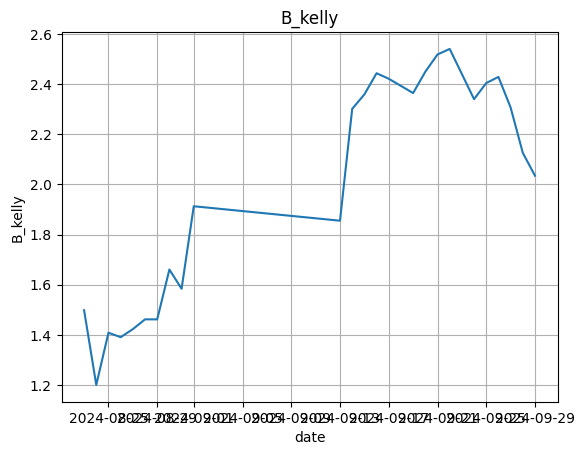

In [119]:
fig, ax = plt.subplots()
ax.plot(dates, B_kelly[1:])
ax.set(xlabel='date', ylabel='B_kelly',
       title='B_kelly')
ax.grid()
plt.show()

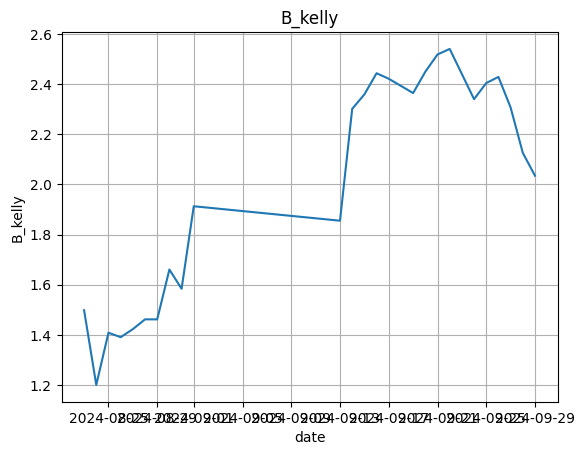

In [115]:
fig, ax = plt.subplots()
ax.plot(dates, B_kelly[1:])
ax.set(xlabel='date', ylabel='B_kelly',
       title='B_kelly')
ax.grid()
plt.show()

In [ ]:
x = result_df[result_df['datetime'] == datetime.datetime(2024, 9, 4)][['prob_home_win', 'prob_draw', 'prob_away_win']].to_numpy()

In [72]:
result_df[result_df['date_match'] == datetime.datetime(2024, 9, 14)][['game', 'prob_home_win', 'prob_draw', 'prob_away_win']]

,game,prob_home_win,prob_draw,prob_away_win
31913,2024-09-14 Espanyol-Alavés,0.431210,0.275045,0.293745
31914,2024-09-14 Mallorca-Villarreal,0.300674,0.297551,0.401775
31915,2024-09-14 Real Sociedad-Real Madrid,0.193398,0.232431,0.574171
31916,2024-09-14 Liverpool-Nott'ham Forest,0.761302,0.166838,0.071859
31917,2024-09-14 Southampton-Manchester Utd,0.166197,0.244800,0.589003
31918,2024-09-14 Manchester City-Brentford,0.799758,0.146567,0.053675
31919,2024-09-14 Fulham-West Ham,0.393903,0.297854,0.308243
31920,2024-09-14 Crystal Palace-Leicester City,0.452015,0.282950,0.265035
31922,2024-09-14 Bournemouth-Chelsea,0.272813,0.255830,0.471358
31923,2024-09-14 Sevilla-Getafe,0.493780,0.269345,0.236875
